# **Uma abordagem de PLN para avaliação de eficiência em leitura**

## **Importação das dependências**

In [ ]:
%pip install -r ../requirements.txt

In [3]:
import ast
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from transformers import AutoTokenizer, AutoModel
from nltk.metrics import edit_distance

d:\UFS\GitHub\pln-edu\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Carregamento dos modelos**

In [4]:
nlp = spacy.load("pt_core_news_lg")
model_name = "PORTULAN/albertina-100m-portuguese-ptbr-encoder"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

## **Funções**

In [35]:
# Cache para embeddings
CACHE_EMBEDDINGS = {}

def get_embedding(palavra):
    """
    Obtém embedding de uma palavra, usando cache quando possível.
    Args:
        palavra (str): Palavra para a qual o embedding será obtido.
    Returns:
        torch.Tensor: Embedding da palavra.
    """
    # Se já está no cache, retorna direto
    if palavra in CACHE_EMBEDDINGS:
        return CACHE_EMBEDDINGS[palavra]
    
    # Se não está no cache, calcula o embedding
    encoded_input = tokenizer([palavra],
                              return_tensors='pt', 
                              padding=True, 
                              truncation=True)
    
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    embedding = model_output.last_hidden_state[:, 0, :].squeeze(0)
    embedding = F.normalize(embedding, p=2, dim=0)
    
    # Armazena no cache para uso futuro
    CACHE_EMBEDDINGS[palavra] = embedding.clone().detach()
    
    return embedding


def similaridade(palavra1, palavra2):
    """
    Calcula a similaridade entre duas palavras usando embeddings e similaridade cosseno.

    Args:
        palavra1 (str): Primeira palavra.
        palavra2 (str): Segunda palavra.
    Returns:
        float: Similaridade cosseno entre as duas palavras.
    """
    emb1 = get_embedding(palavra1)
    emb2 = get_embedding(palavra2)
    
    cos_sim = torch.dot(emb1, emb2).item()
    
    return cos_sim


def pos_tag(palavra):
    """
    Obtém a parte do discurso (POS tag) de uma palavra usando spaCy.
    """
    try:
        doc = nlp(palavra.strip())
        return doc[0].pos_
    
    except Exception as e:
        print(f"Erro ao processar palavra '{palavra}': {e}")

### **Funções de avaliação de lacuna e cálculo de compreensão**

In [ ]:
PESO_CLASSE = 0.4
PESO_SIMILARIDADE = 0.6

def avaliacao_lacuna(gabarito, resposta):
    """
    Avalia uma lacuna do teste de compreensão de leitura.
    Args:
        gabarito (str): Resposta correta esperada.
        resposta (str): Resposta do aluno.
    Returns:
        tuple: Pontuação (float) e tipo de resposta ('correta', 'grafia_incorreta', 'aceitavel', 'classe_correta', 'erro', 'branco').
    """
    # Resposta exata
    if resposta == gabarito:
        return 1, 'correta'

    # Resposta em branco
    elif resposta in ["-", "", " ", None]:
        return 0, 'branco'

    # Resposta esperada porém com a grafia errada
    elif edit_distance(resposta, gabarito) <= (len(resposta)//2):
        return 1, 'grafia_incorreta'

    # Resposta diferente da esperada
    else:
        pos_resposta = pos_tag(resposta)
        pos_gabarito = pos_tag(gabarito)

        # Se a classe gramatical for a mesma
        if pos_resposta == pos_gabarito:
            pontuacao = PESO_CLASSE
            sim = similaridade(resposta, gabarito)

            # Se a similaridade for alta
            if sim >= 0.75:
                pontuacao += sim * PESO_SIMILARIDADE
                return pontuacao, 'aceitavel'
            else:
                return pontuacao, 'classe_correta'

        else:
            return 0, 'erro'


def compreensao_leitura(gabarito, respostas):
    """
    Avalia todas as lacunas do teste e retorna os resultados.

    Args:
        gabarito (list): Lista de respostas corretas do gabarito.
        respostas (list or str): Lista de respostas do aluno ou string com respostas.

    Returns:
        tuple: Compreensão de leitura (float), coeficiente de variação (float) e dicionário com avaliação detalhada.
    """
    if isinstance(respostas, str):
        try:
            respostas = ast.literal_eval(respostas)
        except (ValueError, SyntaxError):
            respostas = [respostas]
    
    avaliacao = {
        'pontuacao': [],
        'correta': 0, 
        'grafia_incorreta': 0, 
        'aceitavel': 0, 
        'classe_correta': 0, 
        'erro': 0, 
        'branco': 0
    }

    for i in range(min(len(respostas), len(gabarito))):
        pontuacao, tipo = avaliacao_lacuna(gabarito[i], respostas[i])
        avaliacao['pontuacao'].append(pontuacao)

        avaliacao[f'{tipo}'] += 1
    
    media = np.mean(avaliacao['pontuacao'])
    cv = np.std(avaliacao['pontuacao']) / media if media > 0 else 0
    
    compreensao = round(media * 100, 3)
    coef_variacao = round(cv, 3)
    
    return compreensao, coef_variacao, avaliacao

### **Cálculo de duração e processamento completo dos dados de Cloze**

In [43]:
def intervalo_tempo(tempo_inicial, tempo_final):
    """
    Calcula o intervalo de tempo em minutos entre os horários de início e término do teste.
    Args:
        tempo_inicial (str or datetime): Hora de início do teste.
        tempo_final (str or datetime): Hora de término do teste.
    Returns:
        int: Intervalo de tempo em minutos.
    """
    tempo_inicial = pd.to_datetime(tempo_inicial)
    tempo_final = pd.to_datetime(tempo_final)
    duracao = tempo_final - tempo_inicial
    duracao = duracao.total_seconds() // 60
    
    return duracao

def processar_dataframe(df, gabarito):
    """
    Processa o dataframe completo e retorna um novo dataframe com as avaliações.
    
    Args:
        df: DataFrame com as colunas originais
        
    Returns:
        DataFrame expandido com colunas de avaliação
    """
    df_resultado = df.copy()
    
    df_resultado['duracao'] = df_resultado.apply(
        lambda row: intervalo_tempo(row['tempo_inicial'], row['tempo_final']), 
        axis=1
    )

    resultados = {
        'compreensao': [],
        'coeficiente_variacao': [],
        'percentual_corretas': [],
        'correta': [],
        'grafia_incorreta': [],
        'aceitavel': [],
        'classe_correta': [],
        'erro': [],
        'branco': []
    }
    
    for _, row in df_resultado.iterrows():     
        compreensao, coef_var, avaliacao = compreensao_leitura(gabarito, row['respostas'])

        resultados['compreensao'].append(compreensao)
        resultados['coeficiente_variacao'].append(coef_var)
        resultados['percentual_corretas'].append(round(avaliacao['correta'] / len(gabarito) * 100, 3))
        resultados['correta'].append(avaliacao['correta'])
        resultados['grafia_incorreta'].append(avaliacao['grafia_incorreta'])
        resultados['aceitavel'].append(avaliacao['aceitavel'])
        resultados['classe_correta'].append(avaliacao['classe_correta'])
        resultados['erro'].append(avaliacao['erro'])
        resultados['branco'].append(avaliacao['branco'])
    
    for coluna, valores in resultados.items():
        df_resultado[coluna] = valores
    
    return df_resultado

## **Visualizações**

In [45]:
def plot_dist_respostas(df, tipo: {'compreensao', 'percentual_corretas'}):
    """
    Plota a distribuição das respostas dos alunos, seja compreensão de leitura ou percentual de acerto.
    Args:
        df (DataFrame): DataFrame contendo os dados de desempenho.
        tipo (str): Tipo de métrica a ser plotada ('compreensao' ou 'percentual_corretas').
    """
    plt.figure(figsize=(5, 5))
    sns.histplot(df[tipo], bins=20, kde=True)
    plt.xlim(0, 100)
    plt.title(f"Distribuição da Compreensão de Leitura - {df['ano'].iloc[0]}º {df['turma'].iloc[0]}" if tipo == 'compreensao' else f"Distribuição do Percentual de Acerto - {df['ano'].iloc[0]}º {df['turma'].iloc[0]}")
    plt.xlabel('Taxa de Compreensão (%)' if tipo == 'compreensao' else 'Taxa de Acerto (%)')
    plt.ylabel('Frequência')
    plt.savefig(f"../docs/results/distribuicao_{tipo}_{df['ano'].iloc[0]}-{df['turma'].iloc[0]}.png")
    plt.show()


def plot_eficiencia_leitura(df, tipo: {'compreensao', 'percentual_corretas'}):
    """
    Plota a eficiência em leitura com base na compreensão de leitura ou percentual de acerto.
    Adaptado de Cardoso et al. (2024) - https://osf.io/47m93/.
    Args:
        df (DataFrame): DataFrame contendo os dados de desempenho.
        tipo (str): Tipo de métrica a ser plotada ('compreensao' ou 'percentual_corretas').
    """
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=tipo, y='duracao', data=df,
                    color='black', s=30)

    media_acertos = np.mean(df[tipo])
    media_duracao = np.mean(df['duracao'])

    plt.axvline(x=media_acertos, color='blue', linestyle='--', linewidth=3)
    plt.axvline(x=44, color='red', linewidth=3)
    plt.axvline(x=58, color='green', linewidth=3)
    plt.axhline(y=media_duracao, color='blue', linestyle='--', linewidth=3)

    plt.title(f"Desempenho do {df['ano'].iloc[0]}º {df['turma'].iloc[0]}\nCompreensão vs Tempo" if tipo == 'compreensao' else f"Desempenho do {df['ano'].iloc[0]}º {df['turma'].iloc[0]}\nPercentual de Acerto vs Tempo", fontsize=14)
    plt.xlabel("Compreensão" if tipo == 'compreensao' else "Percentual de Acerto", fontsize=12)
    plt.ylabel("Tempo", fontsize=12)
    plt.xlim(0, 100)
    plt.ylim(1, 60)

    plt.tight_layout()
    plt.savefig(f"../docs/results/eficiencia_leitura_{tipo}_{df['ano'].iloc[0]}-{df['turma'].iloc[0]}.png")
    plt.show()

## **Avaliação de Teste Cloze**

### **Gabarito do teste**

In [39]:
import json

# Função para carregar o gabarito do teste
def get_gabarito(titulo):
    with open('../data/textos.json', 'r', encoding='utf-8') as file:
        dados_textos = json.load(file)

    df_textos = pd.DataFrame(dados_textos)

    gabarito = df_textos[df_textos['titulo'] == titulo]['respostas'].values[0]
    return gabarito

### **Dataframe dos testes cloze**

In [40]:
df_cloze = pd.read_csv("../data/raw/dados-ctes_29-02-2024.csv", encoding='utf-8')
df_cloze.head()

,discente,ano,turma,texto,respostas,data,tempo_inicial,tempo_final
0,EST_001,9,B,Consumismo entre os jovens,"['como', 'de', 'atribuido', 'de', 'em', 'do', ...",29-02-2024,08:01,08:09
1,EST_002,7,B,Inseguranças no uso das redes sociais,"['melhora', 'Facilidade', 'todo', 'o', 'desgra...",29-02-2024,07:55,08:28
2,EST_003,7,A,Inseguranças no uso das redes sociais,"['tecnologia', '-', '-', 'o', 'dificuldade', '...",29-02-2024,08:03,08:25
3,EST_004,9,A,Consumismo entre os jovens,"['entre', 'a', 'exercida', 'de', 'aos', 'do', ...",29-02-2024,08:02,08:11
4,EST_005,9,A,Consumismo entre os jovens,"['como', 'de', 'jeito', 'de', 'de', 'de', 'soc...",29-02-2024,08:02,08:10


### **Aplicando a avaliação das lacunas**

In [44]:
for texto in df_cloze['texto'].unique():
    gabarito = get_gabarito(texto)

    df_temp = df_cloze[df_cloze['texto'] == texto].copy()
    df_resultado = processar_dataframe(df_temp, gabarito)
    
    df_resultado.to_csv(f"../data/processed/avaliacao-cloze_{df_temp['ano'].iloc[0]}-ano.csv", index=False, encoding='utf-8')

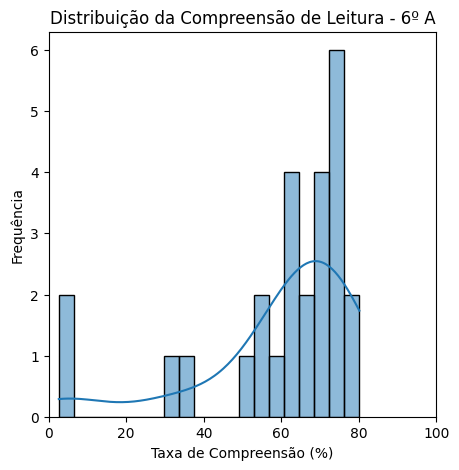

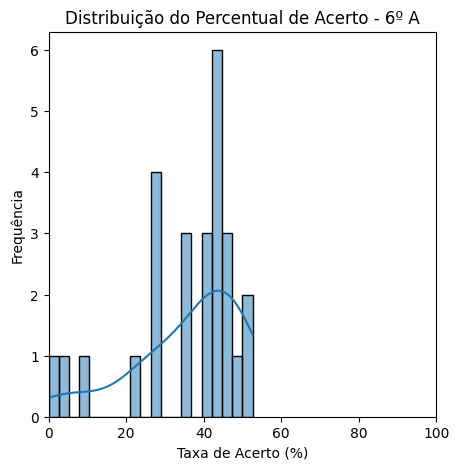

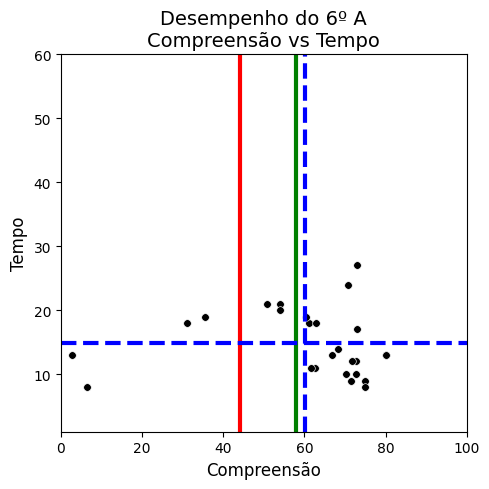

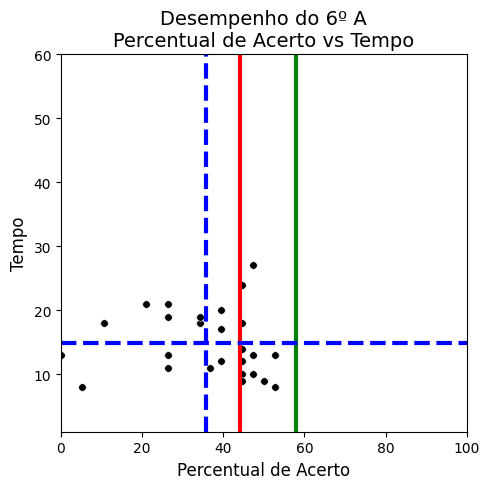

In [48]:
# Visualização dos resultados
df_temp = pd.read_csv("../data/processed/avaliacao-cloze_6-ano.csv", encoding='utf-8')
plot_dist_respostas(df_temp[df_temp['turma'] == 'A'], tipo='compreensao')
plot_dist_respostas(df_temp[df_temp['turma'] == 'A'], tipo='percentual_corretas')    
plot_eficiencia_leitura(df_temp[df_temp['turma'] == 'A'], tipo='compreensao')
plot_eficiencia_leitura(df_temp[df_temp['turma'] == 'A'], tipo='percentual_corretas')
